## Data Analysis and Preprocessing

## Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential
import tensorflow as tf

Functions that modify the Datasets

In [2]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors

def get_season(month):
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_time_of_day(hour):
    hour = int(hour)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
def combine_dataframes(sensor_name,data_meteo):
    data_meteo['DateTime'] = pd.to_datetime(data_meteo['Date'] + ' ' + data_meteo['Hour'])
    
    sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])

    #round the hours to the nearest multiple of 30 minutes
    sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')

    #combine Dataframes by datetime column
    combined = pd.merge(sensor_name, data_meteo, on='DateTime', how='inner')
    combined = combined.drop(columns=["DateTime","Date_y", "Hour_y", "location"])

    combined.rename(columns={'Date_x': 'Date'}, inplace=True)
    combined.rename(columns={'Hour_x': 'Hour'}, inplace=True)
    combined.rename(columns={'TM': 'TM_outdoor'}, inplace=True)
    combined.rename(columns={'HRM%': 'HRM%_outdoor'}, inplace=True)
    combined.rename(columns={'PPT': 'PPT_outdoor'}, inplace=True)
    combined.rename(columns={'RS': 'RS_outdoor'}, inplace=True)
    combined[['Hour', 'Minutes']] = combined['Hour'].str.split(':', expand=True)
    
    #combined['Minutes'] = combined['Minutes'].astype(int)
    combined[['Day', 'Month', 'Year']] = combined['Date'].str.split('-', expand=True)
    #combined['Day'] = combined['Day'].astype(int)
    #combined['Year'] = combined['Year'].astype(int)
    
    #....................................................................
    #Let's create more columns to identify the seasons and time of day
    combined['Season'] = combined['Month'].apply(get_season)
    combined['Time_of_Day'] = combined['Hour'].apply(get_time_of_day)
    
    #OrdinalEncoder - convert categorical data in numerical
    encoder = OrdinalEncoder()
    combined[['Season', 'Time_of_Day']] = encoder.fit_transform(combined[['Season', 'Time_of_Day']])

    #....................................................................
    #We have to divide the ones that have the illumination column and the ones that have light_level
    if 'light_level' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','light_level' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    elif 'illumination' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','illumination' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    
    #....................................................................
    #combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day', 'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]

    return combined


Functions to plot

In [3]:
def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();


def display_outliers(sensor_com):
    sensor_com = sensor_com.drop('light_level', axis=1)
    num_feats = [col for col in sensor_com.columns if sensor_com[col].dtype != 'object']

    fig, axes = plt.subplots(nrows=len(num_feats)//2, ncols=2, figsize=(16, 8 * (len(num_feats)//2)))
    axes = axes.flatten()

    #iterate over numerical features
    for i, col in enumerate(num_feats):
        #boxplot for each feature
        sb.boxplot(x=sensor_com[col], color='red', ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

## LOAD

We have loaded the dataframes and modified the formats so that they are similar

In [4]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})

In [8]:
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")

data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv'

In [436]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [437]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "infrared"])

In [438]:
data_sensors = rename_sensor(data_sensors)

In [439]:
data_sensors.shape

(193215, 11)

Missing Values

In [440]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2                616
humidity           798
illumination    127809
light_level      97889
o3              129341
pressure         32485
temperature        801
tvoc             32307
dtype: int64
Series([], dtype: float64)


In [441]:
"""#tarda como 25 min
data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")"""

In [442]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
illumination    127809
light_level      97889
o3              129341
dtype: int64


Duplicates

In [443]:
data_sensors.duplicated().sum()

0

In [444]:
data_sensors.describe()

_field,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
count,193215.000000,193215.000000,65406.000000,95326.000000,63874.000000,193215.000000,193215.000000,193215.000000
mean,565.605978,46.974533,47.988411,0.442524,0.135181,998.801031,22.834601,142.759276
std,254.628069,11.026851,146.762209,0.914324,0.072241,9.485028,3.990670,175.868772
min,355.000000,20.500000,0.000000,0.000000,0.020000,960.500000,10.800000,0.000000
25%,445.000000,38.500000,1.000000,0.000000,0.060000,993.500000,20.200000,88.000000
50%,476.000000,46.500000,1.000000,0.000000,0.090000,1001.100000,22.700000,100.000000
75%,562.000000,56.000000,9.000000,1.000000,0.210000,1003.900000,25.300000,153.000000
max,3743.000000,77.000000,1365.000000,4.000000,0.260000,1025.400000,36.500000,9738.000000


Minutes Round

In [445]:
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format='%H:%M')
data_sensors['Hour'] = data_sensors['Hour'].apply(lambda x: datetime.strptime(x.strftime('%H:%M'), '%H:%M').replace(minute=(x.minute // 10) * 10))
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')

In [446]:
data_sensors.to_csv("data_sensors_v1.csv",index=False)  

## Recommender System

In [9]:
data_meteo

,Date,Hour,TM,HRM%,PPT,RS
0,25-07-2023,00:00,24.7,73,0.0,0
1,25-07-2023,00:30,24.4,74,0.0,0
2,25-07-2023,01:00,24.1,75,0.0,0
3,25-07-2023,01:30,23.9,75,0.0,0
4,25-07-2023,02:00,23.9,74,0.0,0
...,...,...,...,...,...,...
11995,30-03-2024,21:30,11.9,89,0.0,0
11996,30-03-2024,22:00,12.0,87,0.0,0
11997,30-03-2024,22:30,12.2,88,0.5,0
11998,30-03-2024,23:00,12.7,86,0.0,0


In [10]:
data_sensors = pd.read_csv("data_sensors_v1.csv")
data_sensors

,location,Date,Hour,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
0,testqc2090,25-07-2023,13:50,472.0,36.0,NaN,1.0,0.05,996.9,27.8,100.0
1,testqc2090,25-07-2023,14:00,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
2,testqc2090,25-07-2023,14:10,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
3,testqc2090,25-07-2023,14:20,455.0,36.0,NaN,1.0,0.05,996.8,27.9,100.0
4,testqc2090,25-07-2023,14:30,463.0,36.0,NaN,1.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
193210,Classroom,30-03-2024,11:40,438.0,39.0,11.0,NaN,NaN,976.1,22.0,173.0
193211,Classroom,30-03-2024,11:50,427.0,38.5,9.0,NaN,NaN,976.2,22.3,180.0
193212,Classroom,30-03-2024,12:00,433.0,38.0,7.0,NaN,NaN,976.2,22.5,183.0
193213,Classroom,30-03-2024,12:10,426.0,38.0,9.0,NaN,NaN,976.2,22.7,184.0


In [7]:
data_sensors['location'].unique()

array(['testqc2090', 'Computer_Room', 'Digital_Lab', '24e124128c147446',
       '24e124128c147470', 'OpenLab_Main_Room', 'OpenLab_Laser_Room',
       '24e124725c461468', 'Classroom'], dtype=object)

In [11]:
testqc2090 = data_sensors[data_sensors['location'] == 'testqc2090']
Computer_Room = data_sensors[data_sensors['location'] == 'Computer_Room']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']
c147446 = data_sensors[data_sensors['location'] == '24e124128c147446']
c147470 = data_sensors[data_sensors['location'] == '24e124128c147470']
OpenLab_Main_Room = data_sensors[data_sensors['location'] == 'OpenLab_Main_Room']
OpenLab_Laser_Room = data_sensors[data_sensors['location'] == 'OpenLab_Laser_Room']
c461468 = data_sensors[data_sensors['location'] == '24e124725c461468']
Classroom = data_sensors[data_sensors['location'] == 'Classroom']

We combine the two datasets to have only one (for date and time and for each sensor)

In [12]:
testqc2090_com = combine_dataframes(testqc2090,data_meteo)
Computer_Room_com = combine_dataframes(Computer_Room,data_meteo)
Digital_Lab_com = combine_dataframes(Digital_Lab,data_meteo)
c147446_com = combine_dataframes(c147446,data_meteo)
c147470_com = combine_dataframes(c147470,data_meteo)
OpenLab_Main_Room_com = combine_dataframes(OpenLab_Main_Room,data_meteo)
OpenLab_Laser_Room_com = combine_dataframes(OpenLab_Laser_Room,data_meteo)
c461468_com = combine_dataframes(c461468,data_meteo)
Classroom_com = combine_dataframes(Classroom,data_meteo)

C:\Users\migue\AppData\Local\Temp\ipykernel_23364\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])
C:\Users\migue\AppData\Local\Temp\ipykernel_23364\2267462829.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')
C:\Users\migue\AppData\Local\Temp\ipykernel_23364\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a 

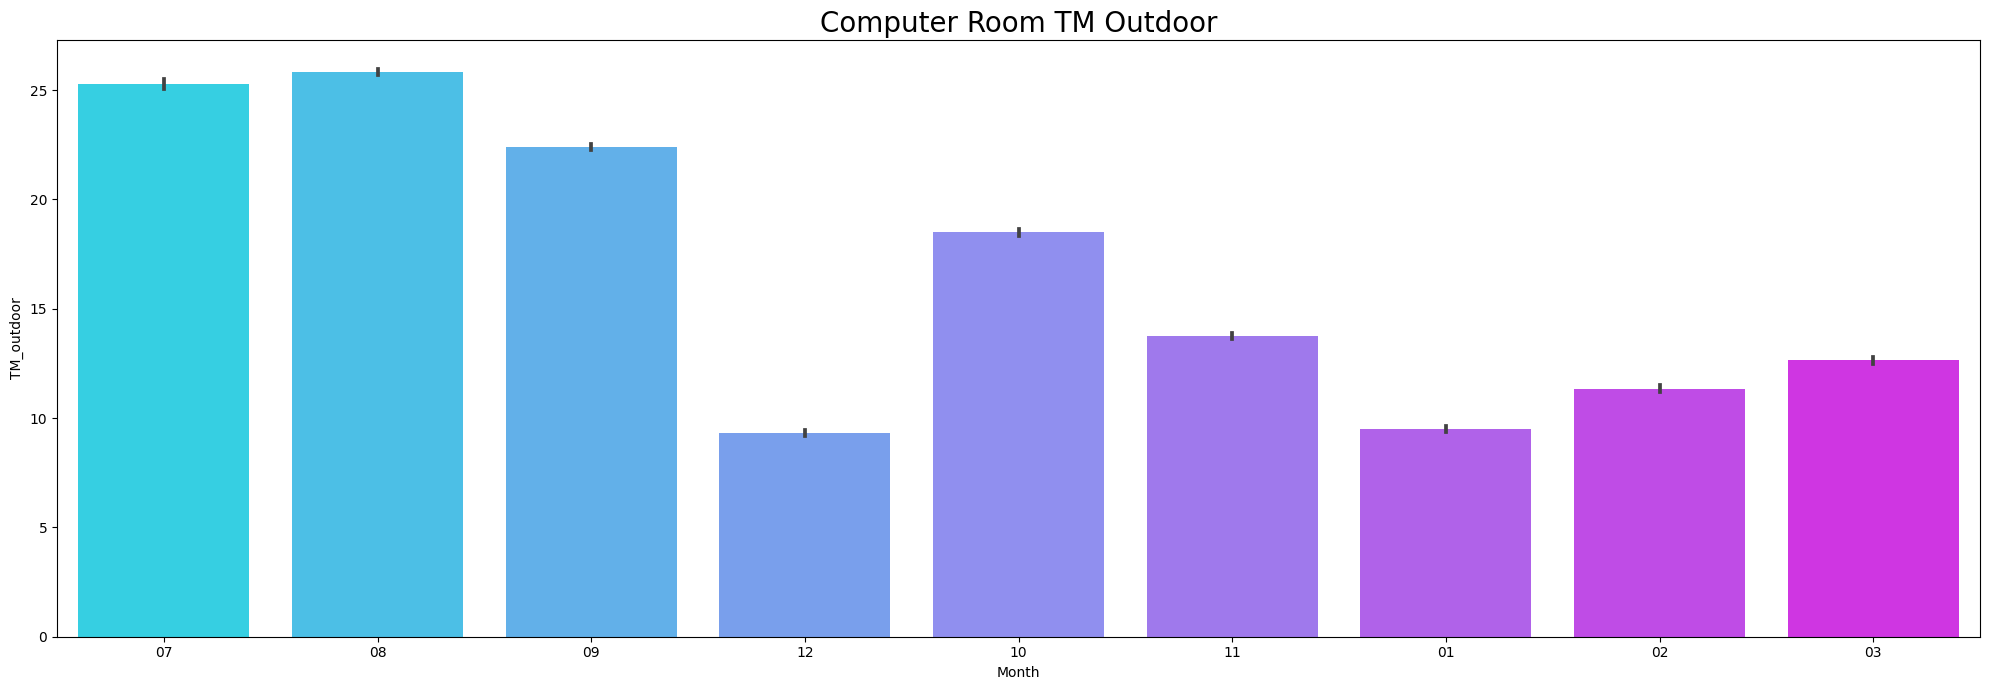

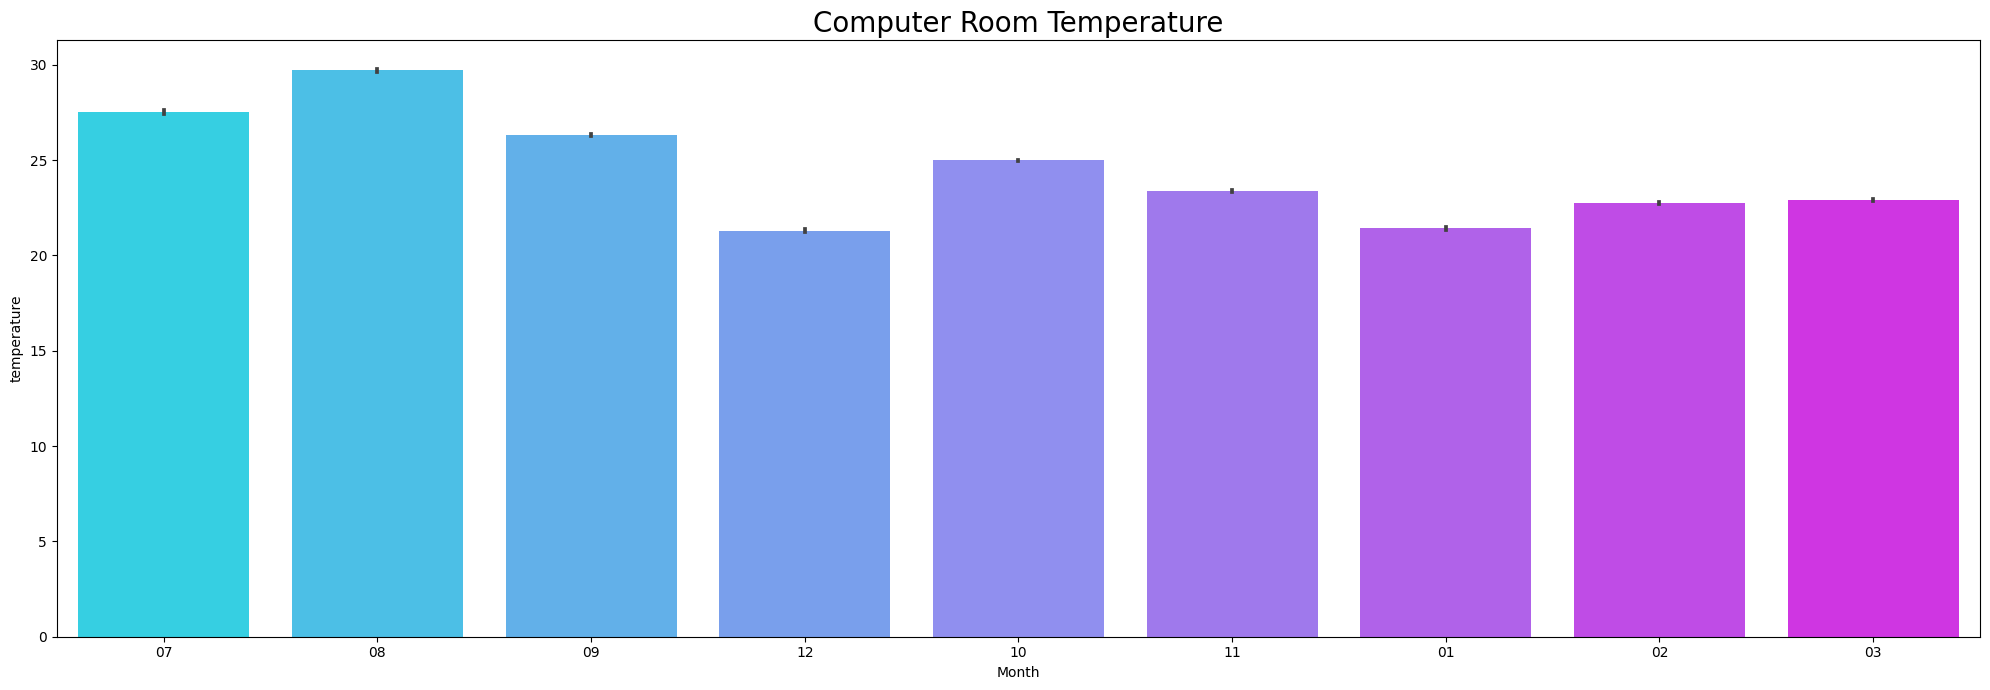

In [16]:
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['TM_outdoor'], "Computer Room TM Outdoor")
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['temperature'], "Computer Room Temperature")

In [17]:
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
table = TableOne(Computer_Room_com.drop(['Day', 'Month', 'Year','Hour', "Minutes", "o3"], axis = 1), dip_test=True, normal_test=True, tukey_test=True)
table

Missing        Overall
n                                             31489
Season, n (%)          0.0         0   11225 (35.6)
                       1.0              3355 (10.7)
                       2.0              5347 (17.0)
                       3.0             11562 (36.7)
Time_of_Day, n (%)     0.0         0    7940 (25.2)
                       1.0              5232 (16.6)
                       2.0              9196 (29.2)
                       3.0              9121 (29.0)
light_level, n (%)     0.0        14   23412 (74.4)
                       1.0              4313 (13.7)
                       2.0               1137 (3.6)
                       3.0                949 (3.0)
                       4.0               1664 (5.3)
co2, mean (SD)                     0   451.2 (90.4)
humidity, n (%)        22.0        0        1 (0.0)
                       22.5                 8 (0.0)
                       23.0                22 (0.1)
                       23.5                39 (0.1)
                       24.0                39 (0.1)
                       24.5                44 (0.1)
                       25.0                93 (0.3)
                       25.5               159 (0.5)
                       26.0               209 (0.7)
                       26.5               304 (1.0)
                       27.0               310 (1.0)
                       27.5               350 (1.1)
                       28.0               298 (0.9)
                       28.5               324 (1.0)
                       29.0               400 (1.3)
                       29.5               532 (1.7)
                       30.0               494 (1.6)
                       30.5               567 (1.8)
                       31.0               619 (2.0)
                       31.5               610 (1.9)
                       32.0               592 (1.9)
                       32.5               765 (2.4)
                       33.0               826 (2.6)
                       33.5               890 (2.8)
                       34.0               972 (3.1)
                       34.5               792 (2.5)
                       35.0               664 (2.1)
                       35.5               528 (1.7)
                       36.0               570 (1.8)
                       36.5               551 (1.7)
                       36.75                1 (0.0)
                       37.0               493 (1.6)
                       37.25                1 (0.0)
                       37.5               682 (2.2)
                       38.0               819 (2.6)
                       38.25                1 (0.0)
                       38.5               680 (2.2)
                       39.0               627 (2.0)
                       39.5               700 (2.2)
                       40.0               587 (1.9)
                       40.5               551 (1.7)
                       41.0               631 (2.0)
                       41.5               752 (2.4)
                       41.75                1 (0.0)
                       42.0               797 (2.5)
                       42.5               736 (2.3)
                       43.0               685 (2.2)
                       43.5               613 (1.9)
                       44.0               434 (1.4)
                       44.5               378 (1.2)
                       45.0               394 (1.3)
                       45.5               495 (1.6)
                       46.0               457 (1.5)
                       46.5               528 (1.7)
                       47.0               497 (1.6)
                       47.5               333 (1.1)
                       48.0               354 (1.1)
                       48.5               325 (1.0)
                       49.0               284 (0.9)
                       49.5               314 (1.0)
                       50.0               322 (1.0)
                       50

Tukey test indicates far outliers

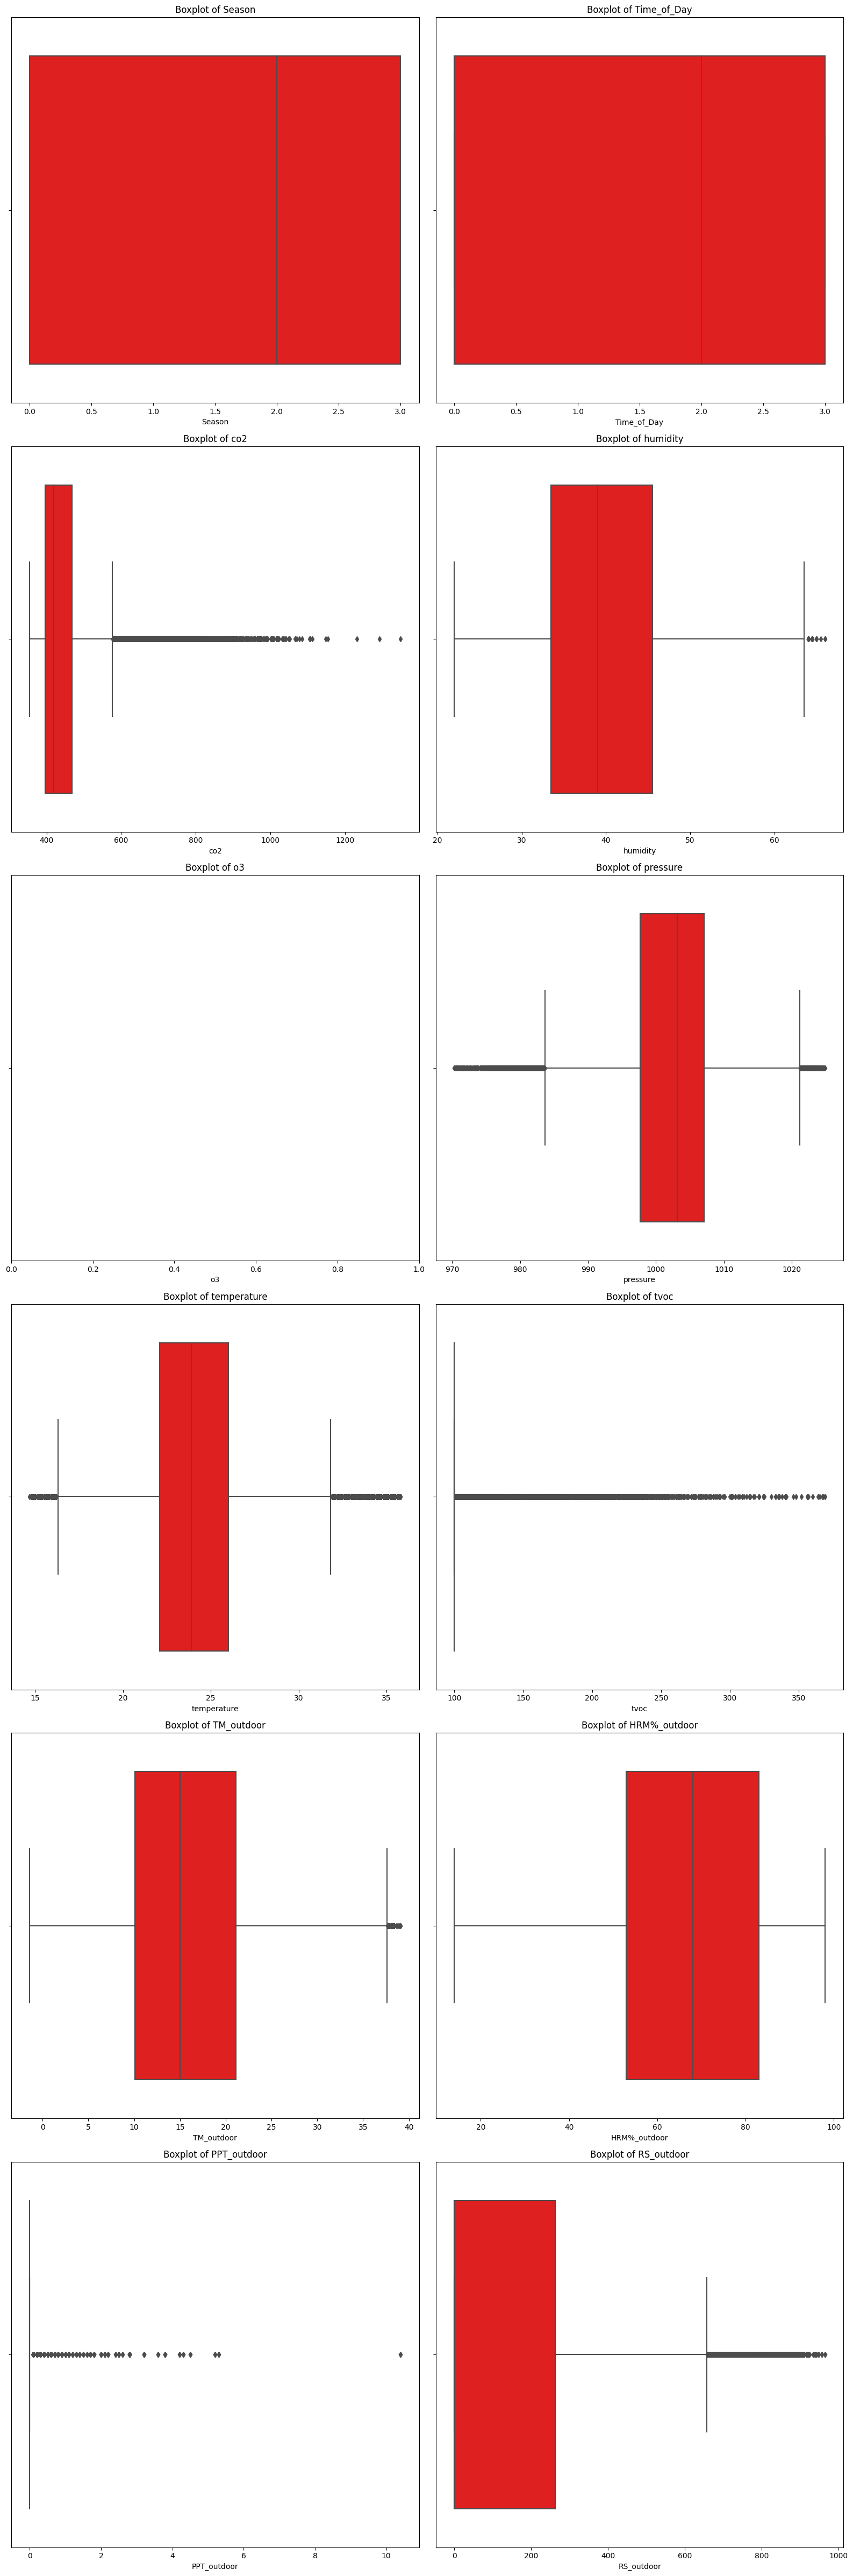

"Q1 = Computer_Room_com['co2'].quantile(0.25)\nQ3 = Computer_Room_com['co2'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noutliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]\n\noutliers_co2"

In [13]:
display_outliers(Computer_Room_com)
"""Q1 = Computer_Room_com['co2'].quantile(0.25)
Q3 = Computer_Room_com['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]

outliers_co2"""

Correlations

In [14]:
Computer_Room_com['Day'] = pd.to_numeric(Computer_Room_com['Day'])
Computer_Room_com['Month'] = pd.to_numeric(Computer_Room_com['Month'])
Computer_Room_com['Year'] = pd.to_numeric(Computer_Room_com['Year'])
Computer_Room_com['Hour'] = pd.to_numeric(Computer_Room_com['Hour'])
Computer_Room_com['Minutes'] = pd.to_numeric(Computer_Room_com['Minutes'])

<Axes: >

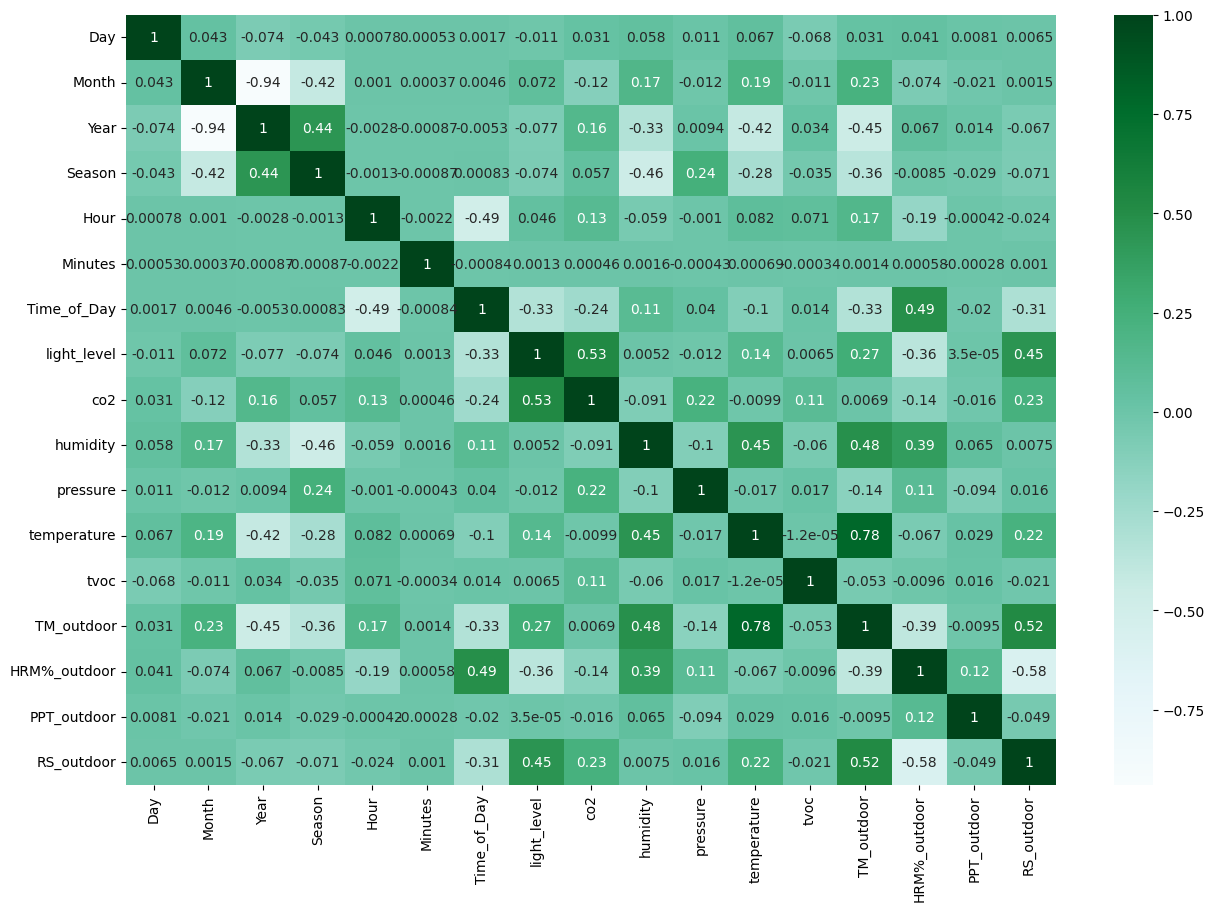

In [15]:
plt.figure(figsize=(15, 10))
sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)

It can be seen that the columns co2, pressure, tvoc do not have a correlation with any of the other variables. This is because they are totally independent and are not affected by the others.

Since, for example, the CO2 and TVOC columns are variables related to the air quality of the room itself.

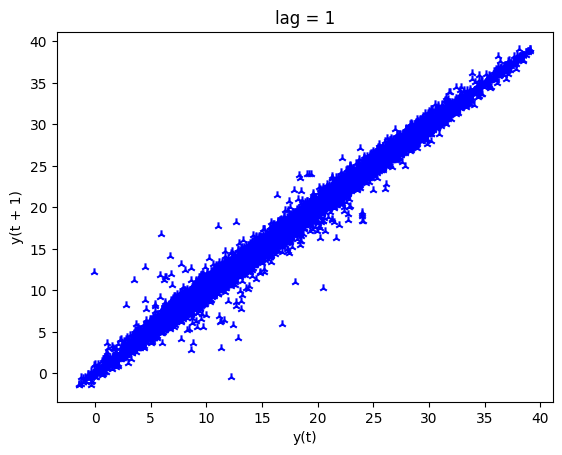

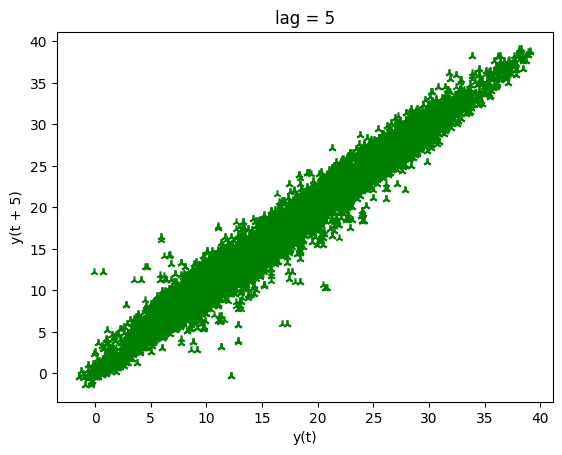

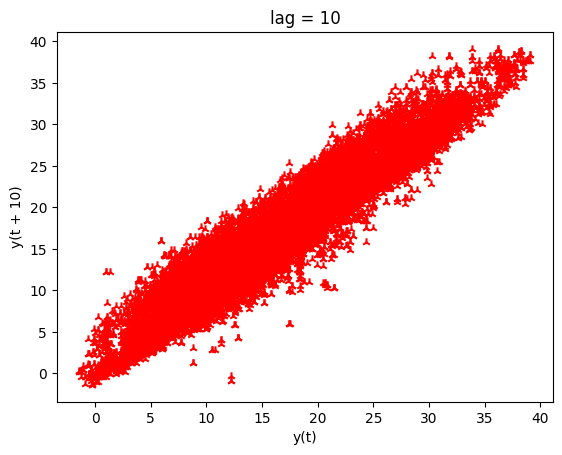

In [16]:
from pandas.plotting import lag_plot
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=1, marker='2', c='blue')
plt.title('lag = 1')
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=5, marker='2', c='green')
plt.title('lag = 5');
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=10, marker='2', c='red')
plt.title('lag = 10');

In [16]:
Computer_Room_com

,Day,Month,Year,Season,Hour,Minutes,Time_of_Day,light_level,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,7,2023,2.0,13,50,0.0,1.0,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,7,2023,2.0,14,0,0.0,1.0,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,7,2023,2.0,14,10,0.0,1.0,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,7,2023,2.0,14,20,0.0,1.0,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,7,2023,2.0,14,30,0.0,1.0,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,3,2024,1.0,11,40,2.0,0.0,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,3,2024,1.0,11,50,2.0,0.0,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,3,2024,1.0,12,0,0.0,0.0,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,3,2024,1.0,12,10,0.0,0.0,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


## Bidirectional and Unidirectional LSTM

In [80]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

class NNPredictionModel:
    def __init__(self, input_shape, output_units=3):
        self.temperature_model_1 = self.temp_uni_LSTM(input_shape, output_units)
        self.temperature_model_2 = self.temp_bi_LSTM(input_shape, output_units)
        self.temperature_model_3 = self.temp_uni2_LSTM(input_shape, output_units)
        self.co2_model_1 = self.co2_uni_LSTM(input_shape, output_units)
        self.co2_model_2 = self.co2_bi_LSTM(input_shape, output_units)

    def temp_uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(64, activation='tanh', return_sequences=True),
            Dropout(0.2),
            LSTM(64, activation='tanh'),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model
    
    def temp_uni2_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            LSTM(64, activation='tanh', kernel_regularizer=l2(0.01)),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def temp_bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            tf.keras.layers.Dropout(0.20),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

    def co2_uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(64, activation='tanh', kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def co2_bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            #tf.keras.layers.Dropout(0.3),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

In [81]:
def model_train_evaluation(y, X, model, model_name, label):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=30,validation_split=0.001)#, callbacks=early_stop)
    history_frame = pd.DataFrame(history.history)
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel(label)
    plt.ylabel(label)
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()

## Temperature Prediction

In [82]:
df_train=Computer_Room_com[["Month","Hour","Minutes","light_level",'RS_outdoor', "TM_outdoor","temperature"]]
print(len(df_train.columns))

7


In [83]:
df_train

,Month,Hour,Minutes,light_level,RS_outdoor,TM_outdoor,temperature
0,7,13,50,1.0,808,31.0,27.4
1,7,14,0,1.0,808,31.0,27.5
2,7,14,10,1.0,808,31.0,27.5
3,7,14,20,1.0,746,31.2,27.5
4,7,14,30,1.0,746,31.2,27.6
...,...,...,...,...,...,...,...
31484,3,11,40,0.0,340,15.4,22.2
31485,3,11,50,0.0,340,15.0,22.4
31486,3,12,0,0.0,340,15.0,22.6
31487,3,12,10,0.0,340,15.0,22.8


In [84]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [85]:
df_train = df_train.fillna(0)

In [86]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [87]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 7)

In [88]:
lags=15
forecasts=1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 7), (31473, 15, 7), (31473, 1))

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 7), (25178, 1), (6295, 15, 7), (6295, 1))

In [90]:
X_train, y_train, X_val, y_val

(array([[[ 0.19897416, -0.94147936, -0.29240887, ..., -0.52766471,
           1.32944889,  2.55867746],
         [ 0.19897416, -0.94147936,  0.29361855, ..., -0.52766471,
           1.32944889,  2.55867746],
         [ 0.19897416, -0.94147936,  0.87964597, ..., -0.52766471,
           1.32944889,  2.55867746],
         ...,
         [ 0.19897416, -0.65181675, -0.29240887, ...,  1.0628854 ,
           1.91008917,  2.82183566],
         [ 0.19897416, -0.65181675,  0.29361855, ...,  1.0628854 ,
           1.91008917,  2.82183566],
         [ 0.19897416, -0.65181675,  0.87964597, ...,  1.0628854 ,
           1.91008917,  2.85107546]],
 
        [[ 1.19913339,  0.94132758, -0.87843628, ..., -0.65300698,
          -0.59722113, -0.1606239 ],
         [ 1.19913339,  0.94132758, -0.29240887, ..., -0.65300698,
          -0.75557757, -0.1606239 ],
         [ 1.19913339,  0.94132758,  0.29361855, ..., -0.65300698,
          -0.75557757, -0.1898637 ],
         ...,
         [ 1.19913339,  1.2309901

In [92]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.temperature_model_1
bi_model = model.temperature_model_2
uni2_model = model.temperature_model_3

bi_model.summary()
#tf.keras.utils.plot_model(bi_model)

uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_42                │ (None, 15, 512)        │       540,672 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 15, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ (None, 15, 256)        │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 15, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 866,385 (3.30 MB)

 Trainable params: 866,385 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_105 (LSTM)                 │ (None, 15, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_106 (LSTM)                 │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_107 (LSTM)                 │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,129 (594.25 KB)

 Trainable params: 152,129 (594.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0709 - val_loss: 0.0104
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0101 - val_loss: 0.0035
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0046 - val_loss: 8.9035e-04
Epoch 12/30
786/786 ━━━━━━

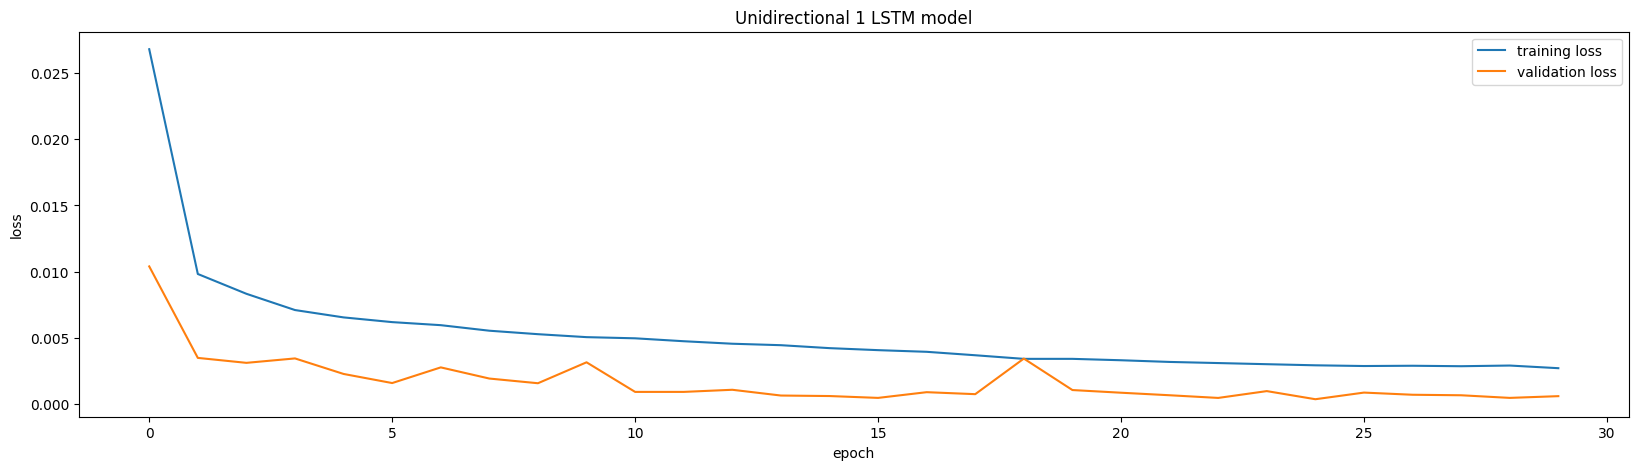

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 1 LSTM model : 0.021295536079880717
Mean Squared Error(MSE) of Unidirectional 1 LSTM model : 0.0016129907661324764
Root Mean Squared Error (RMSE) of Unidirectional 1 LSTM model : 0.040162056298606974
Mean absolute percentage error (MAPE) of Unidirectional 1 LSTM model : 0.08276224768963936
Explained Variance Score (EVS) of Unidirectional 1 LSTM model : 0.9984360122835586
R2 of Unidirectional 1 LSTM model : 1.0

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


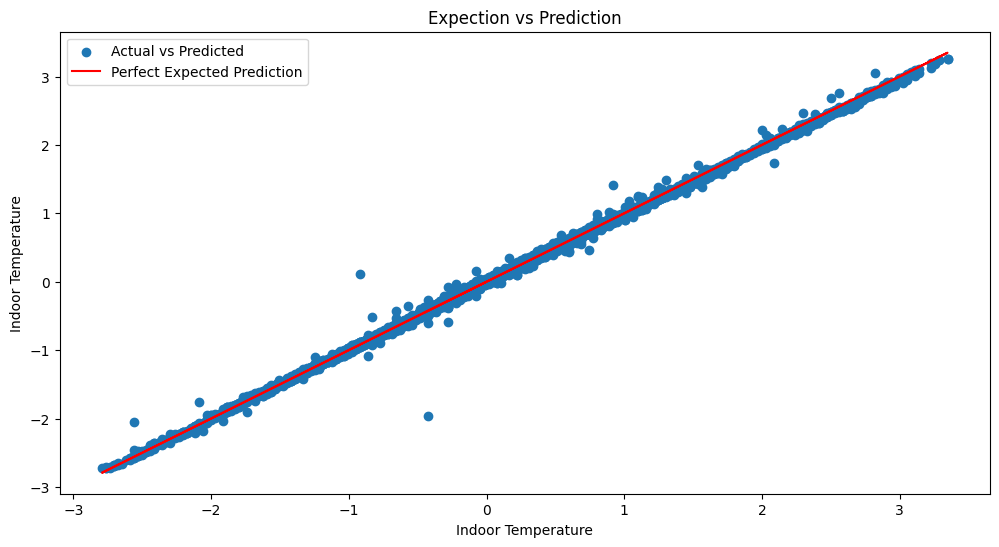

In [93]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM model', 'Indoor Temperature')

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.0825 - val_loss: 0.0058
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0237 - val_loss: 0.0066
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0208 - val_loss: 0.0044
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0192 - val_loss: 0.0012
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.0184 - val_loss: 0.0069
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.0176 - val_loss: 0.0043
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0179 - val_loss: 0.0084
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.0187 - val_loss: 0.0011
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.0179 - val_loss: 0.0012
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - loss: 0.0199 - val_loss: 0.0071
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - loss: 0.0186 - val_loss: 0.0018
Epoch 12/30
786/786 ━━━━━━━━━━

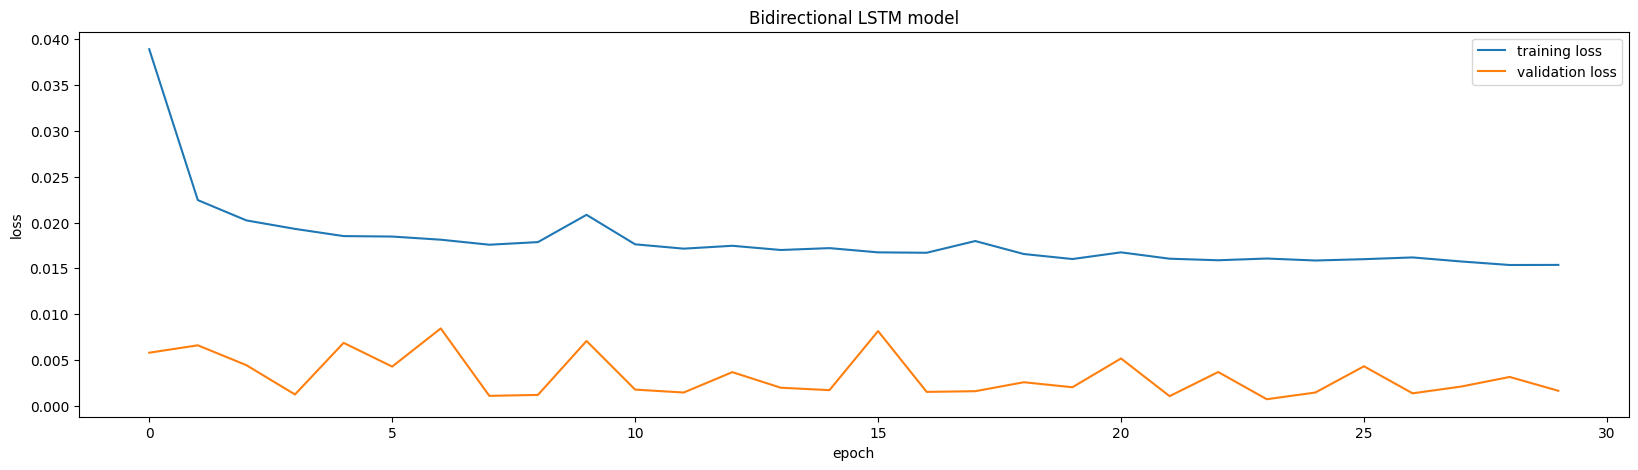

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.03689231934605142
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.003893062212183322
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.062394408500949204
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.10581579198196814
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9962538640205871
R2 of Bidirectional LSTM model : 1.0

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


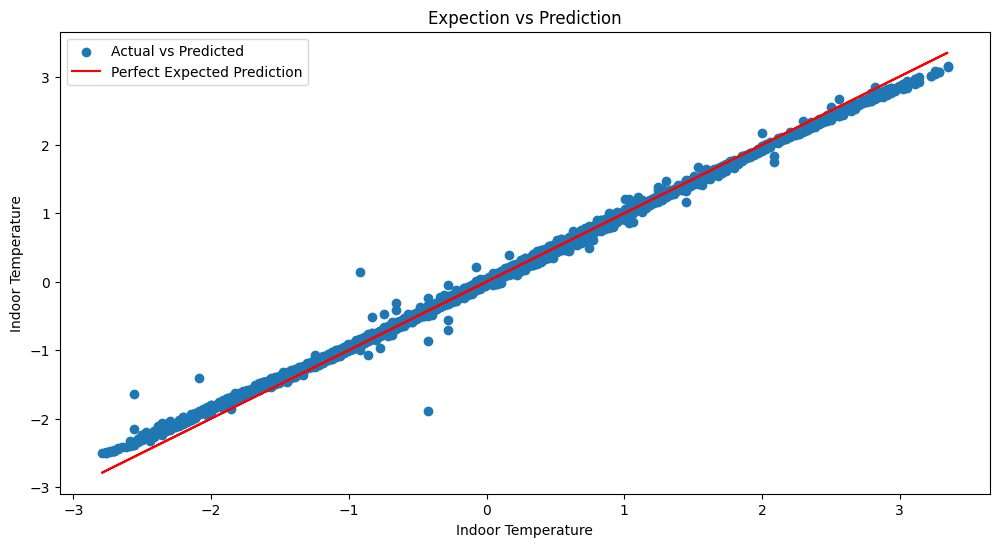

In [94]:
#model_train_evaluation(y_val, X_val,bi_model, 'Bidirectional LSTM model', 'Indoor Temperature')

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 1.1367 - val_loss: 0.0650
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0476 - val_loss: 0.0362
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0313 - val_loss: 0.0290
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0283 - val_loss: 0.0250
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0249 - val_loss: 0.0219
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0240 - val_loss: 0.0223
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0217 - val_loss: 0.0302
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0196 - val_loss: 0.0130
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0198 - val_loss: 0.0247
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0184 - val_loss: 0.0117
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0178 - val_loss: 0.0135
Epoch 12/30
786/786 ━━━━━━━━━━

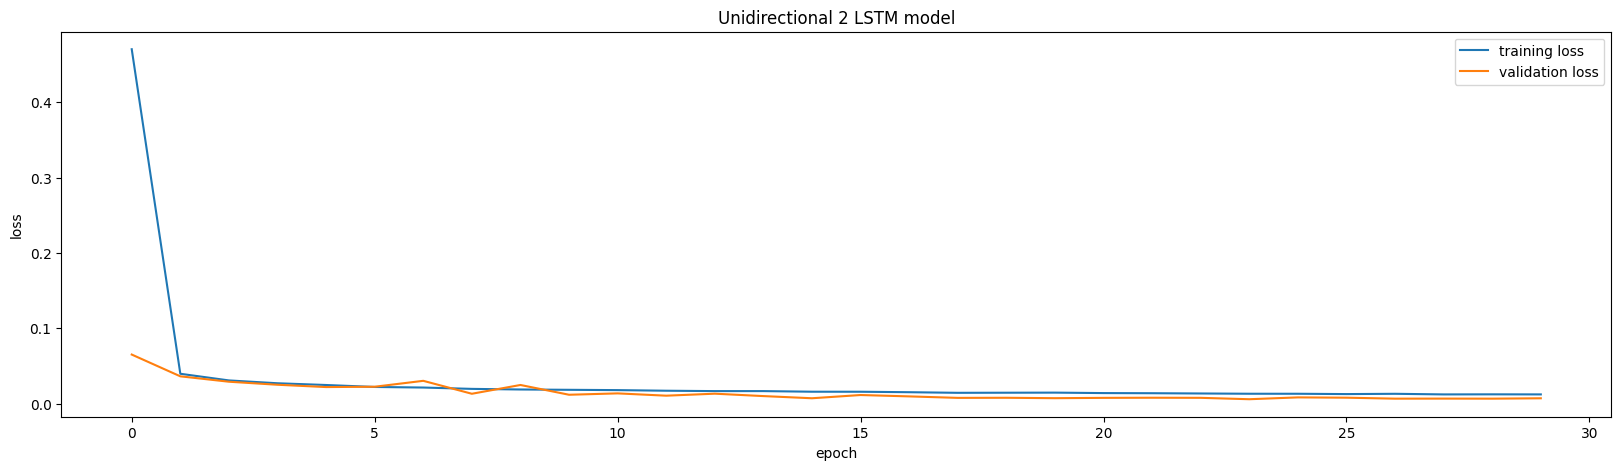

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 2 LSTM model : 0.0448067860737647
Mean Squared Error(MSE) of Unidirectional 2 LSTM model : 0.005888557665955459
Root Mean Squared Error (RMSE) of Unidirectional 2 LSTM model : 0.07673693808040205
Mean absolute percentage error (MAPE) of Unidirectional 2 LSTM model : 0.201164420867364
Explained Variance Score (EVS) of Unidirectional 2 LSTM model : 0.9943882283919765
R2 of Unidirectional 2 LSTM model : 0.99

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


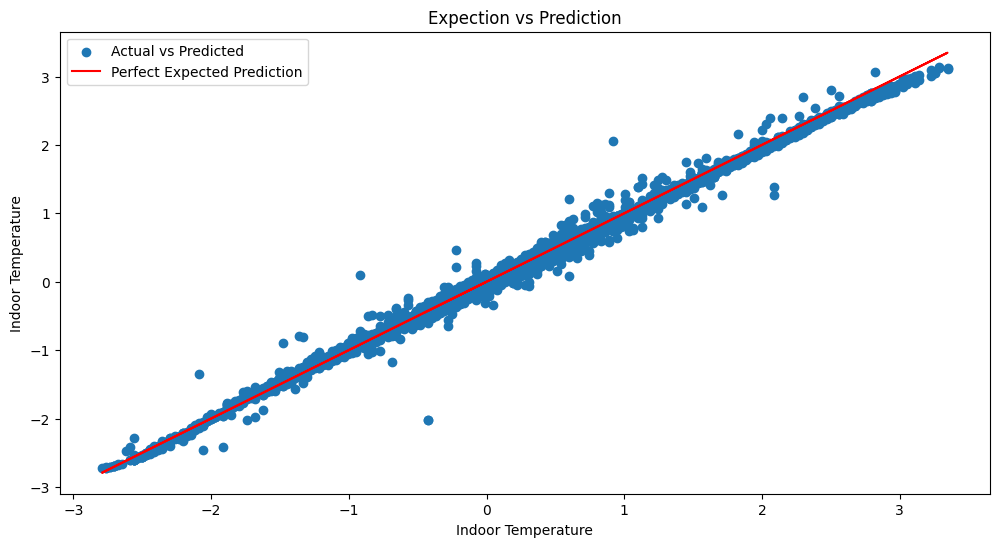

In [95]:
#model_train_evaluation(y_val, X_val, uni2_model, 'Unidirectional 2 LSTM model', 'Indoor Temperature')

In [96]:
import pandas as pd

data_test = {
    'Day': ['09','09', '09', '09', '09', '09', '09', '09', '09', '09'],
    'Hour': ['14', '14', '14', '14', '14', '14', '15', '15', '15', '15'],
    'Minutes': ['00', '10', '20', '30', '40', '50', '00', '10', '20', '30'],
    'Season': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'Time_of_Day': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'light_level': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
}

df_new = pd.DataFrame(data_test)

In [97]:
df_test=df_new[['Day', "Hour", "Minutes", 'Season',"Time_of_Day"]]
df_test

,Day,Hour,Minutes,Season,Time_of_Day
0,09,14,00,1.0,0.0
1,09,14,10,1.0,0.0
2,09,14,20,1.0,0.0
3,09,14,30,1.0,0.0
4,09,14,40,1.0,0.0
5,09,14,50,1.0,0.0
6,09,15,00,1.0,0.0
7,09,15,10,1.0,0.0
8,09,15,20,1.0,0.0
9,09,15,30,1.0,0.0


In [98]:
train_test=df_train.append(df_test,ignore_index=True).fillna(0)
train_test

C:\Users\migue\AppData\Local\Temp\ipykernel_23364\237083430.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test=df_train.append(df_test,ignore_index=True).fillna(0)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


,Month,Hour,Minutes,light_level,RS_outdoor,TM_outdoor,temperature,Day,Season,Time_of_Day
0,7.0,13,50,1.0,808.0,31.0,27.4,0,0.0,0.0
1,7.0,14,0,1.0,808.0,31.0,27.5,0,0.0,0.0
2,7.0,14,10,1.0,808.0,31.0,27.5,0,0.0,0.0
3,7.0,14,20,1.0,746.0,31.2,27.5,0,0.0,0.0
4,7.0,14,30,1.0,746.0,31.2,27.6,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
31494,0.0,14,50,0.0,0.0,0.0,0.0,09,1.0,0.0
31495,0.0,15,00,0.0,0.0,0.0,0.0,09,1.0,0.0
31496,0.0,15,10,0.0,0.0,0.0,0.0,09,1.0,0.0
31497,0.0,15,20,0.0,0.0,0.0,0.0,09,1.0,0.0


In [103]:
y_mean=df_train['temperature'].mean()
y_std=scaler.scale_[df_train.shape[1]-4]
y_mean, y_std

(24.249333100447775, 1.0663238534928792)

In [104]:
for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=uni_model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std*val[:,0]+y_mean
    train_test.loc[i,'temperature']=val2
    
final_test = train_test[len(df_train):][['temperature']]
final_test

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Day
- Season
- Time_of_Day


## Quality-Air Prediction co2

In [105]:
df_train=Computer_Room_com[["Day",'Season',"Hour","Minutes","light_level","co2"]]
print(len(df_train.columns))#RS_outdoor

6


In [106]:
df_train

,Day,Season,Hour,Minutes,light_level,co2
0,25,2.0,13,50,1.0,431.0
1,25,2.0,14,0,1.0,426.0
2,25,2.0,14,10,1.0,438.0
3,25,2.0,14,20,1.0,425.0
4,25,2.0,14,30,1.0,442.0
...,...,...,...,...,...,...
31484,30,1.0,11,40,0.0,405.0
31485,30,1.0,11,50,0.0,399.0
31486,30,1.0,12,0,0.0,403.0
31487,30,1.0,12,10,0.0,398.0


In [107]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [108]:
df_train = df_train.fillna(0)

In [109]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [110]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 6)

In [111]:
lags=15
forecasts= 1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 6), (31473, 15, 6), (31473, 1))

In [112]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 6), (25178, 1), (6295, 15, 6), (6295, 1))

In [113]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.co2_model_1
bi_model = model.co2_model_2

bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_51                │ (None, 15, 512)        │       538,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 15, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 15, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 15, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_52                │ (None, 15, 256)        │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 15, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 15, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 15, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_53                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 864,577 (3.30 MB)

 Trainable params: 864,457 (3.30 MB)

 Non-trainable params: 120 (480.00 B)

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_129 (LSTM)                 │ (None, 15, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 15, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_131 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,457 (982.25 KB)

 Trainable params: 250,817 (979.75 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 4.0104 - val_loss: 0.9502
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.8361 - val_loss: 0.2416
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.3120 - val_loss: 0.1161
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1919 - val_loss: 0.0827
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1713 - val_loss: 0.0664
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1559 - val_loss: 0.0596
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1629 - val_loss: 0.0664
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1396 - val_loss: 0.0675
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.1470 - val_loss: 0.1047
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1429 - val_loss: 0.0501
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1351 - val_loss: 0.1402
Epoch 12/30
786/786 ━━━━━━━━━━

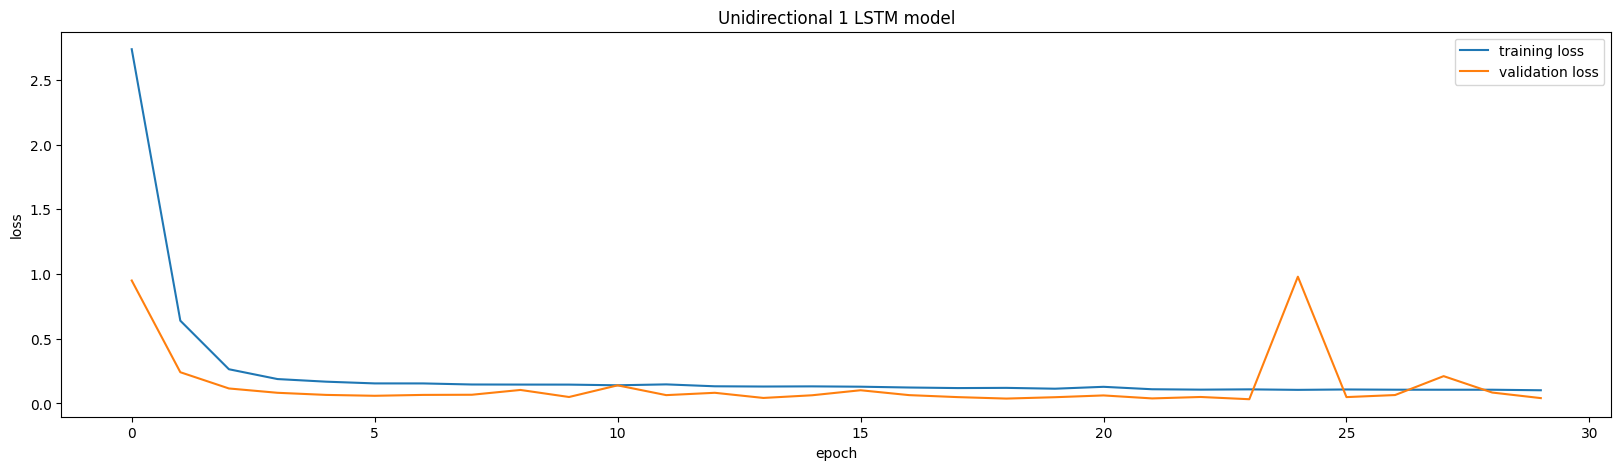

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 1 LSTM model : 0.1464830576181919
Mean Squared Error(MSE) of Unidirectional 1 LSTM model : 0.05687488775731802
Root Mean Squared Error (RMSE) of Unidirectional 1 LSTM model : 0.2384845650295172
Mean absolute percentage error (MAPE) of Unidirectional 1 LSTM model : 0.9023720690728813
Explained Variance Score (EVS) of Unidirectional 1 LSTM model : 0.9466603243121124
R2 of Unidirectional 1 LSTM model : 0.94

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


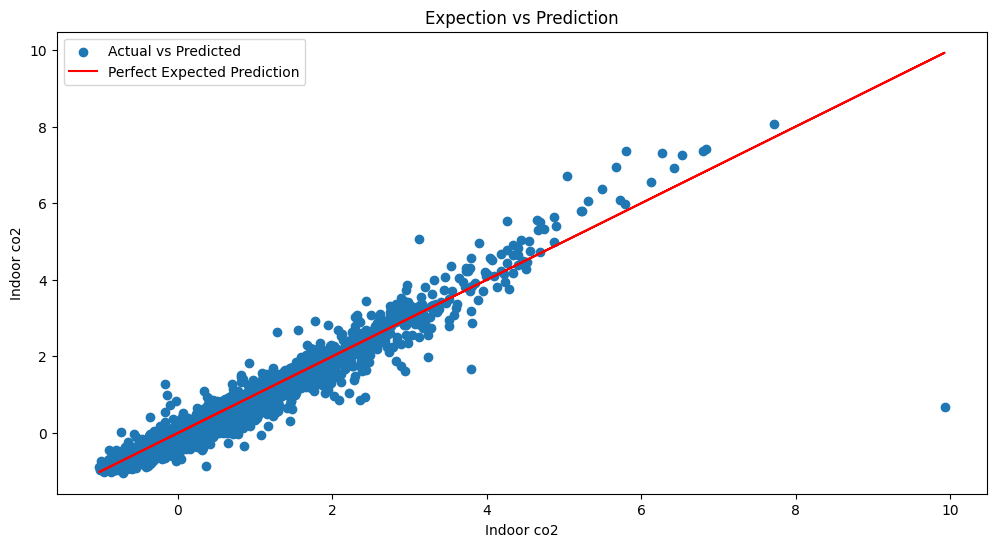

In [114]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM model', 'Indoor co2')

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - loss: 0.8372 - val_loss: 0.0394
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.1786 - val_loss: 0.0300
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.1502 - val_loss: 0.0280
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.1413 - val_loss: 0.0301
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.1261 - val_loss: 0.0398
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.1254 - val_loss: 0.1932
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.1234 - val_loss: 0.0411
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.1232 - val_loss: 0.0211
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.1210 - val_loss: 0.0238
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.1118 - val_loss: 0.0247
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.1156 - val_loss: 0.0380
Epoch 12/30
786/786 ━━━━━━━━━━

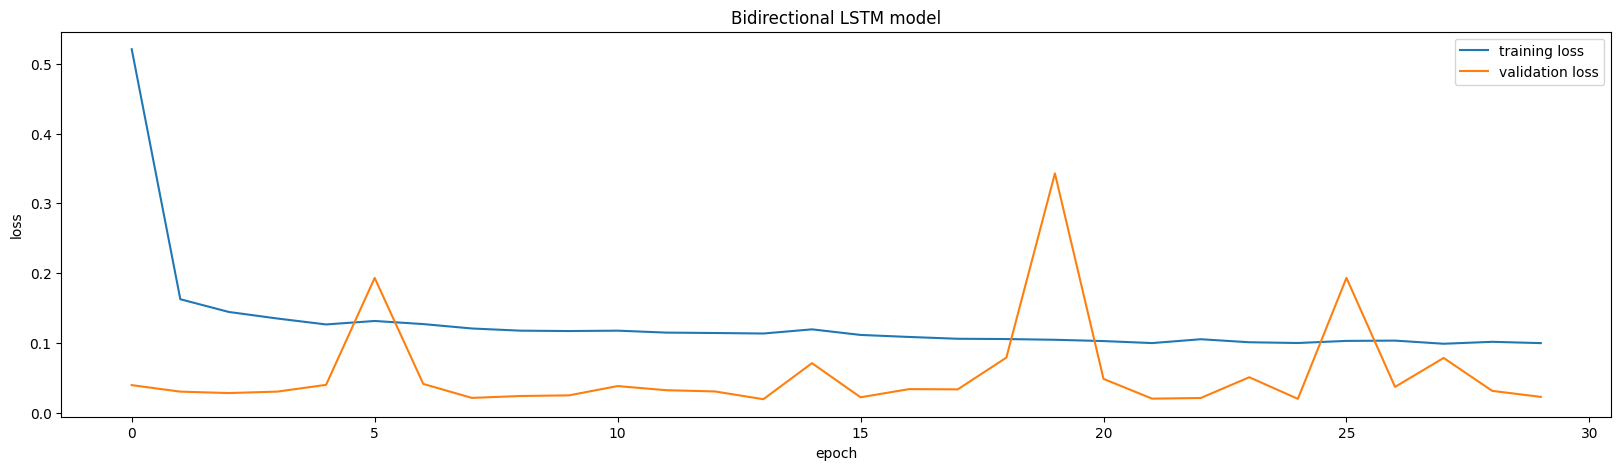

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.13621809405088475
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.04945678003705646
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.22238880375831976
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.7943910189975122
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9514823226240826
R2 of Bidirectional LSTM model : 0.95

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


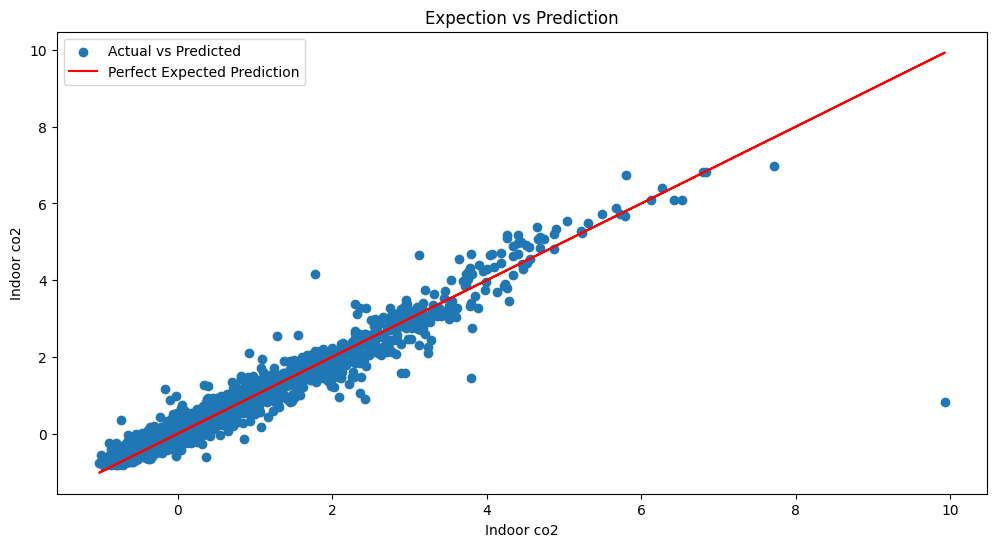

In [115]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM model', 'Indoor co2')

## Quality-Air Prediction tvoc

In [116]:
df_train=Computer_Room_com[["Day","Hour","Minutes","Time_of_Day","light_level","tvoc"]]
print(len(df_train.columns))

6


In [117]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [118]:
df_train = df_train.fillna(0)

In [119]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 6)

In [120]:
lags=15
forecasts= 1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 6), (31473, 15, 6), (31473, 1))

In [121]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 6), (25178, 1), (6295, 15, 6), (6295, 1))

In [122]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.co2_model_1
bi_model = model.co2_model_2

#bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
#uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 3.8542 - val_loss: 1.2901
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.7805 - val_loss: 0.4955
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.3558 - val_loss: 0.3174
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2876 - val_loss: 0.2685
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2604 - val_loss: 0.3139
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2291 - val_loss: 1.0323
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2445 - val_loss: 0.4501
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1830 - val_loss: 0.1823
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2018 - val_loss: 0.1597
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1747 - val_loss: 0.2811
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.1767 - val_loss: 0.4195
Epoch 12/30
786/786 ━━━━━━━━━━

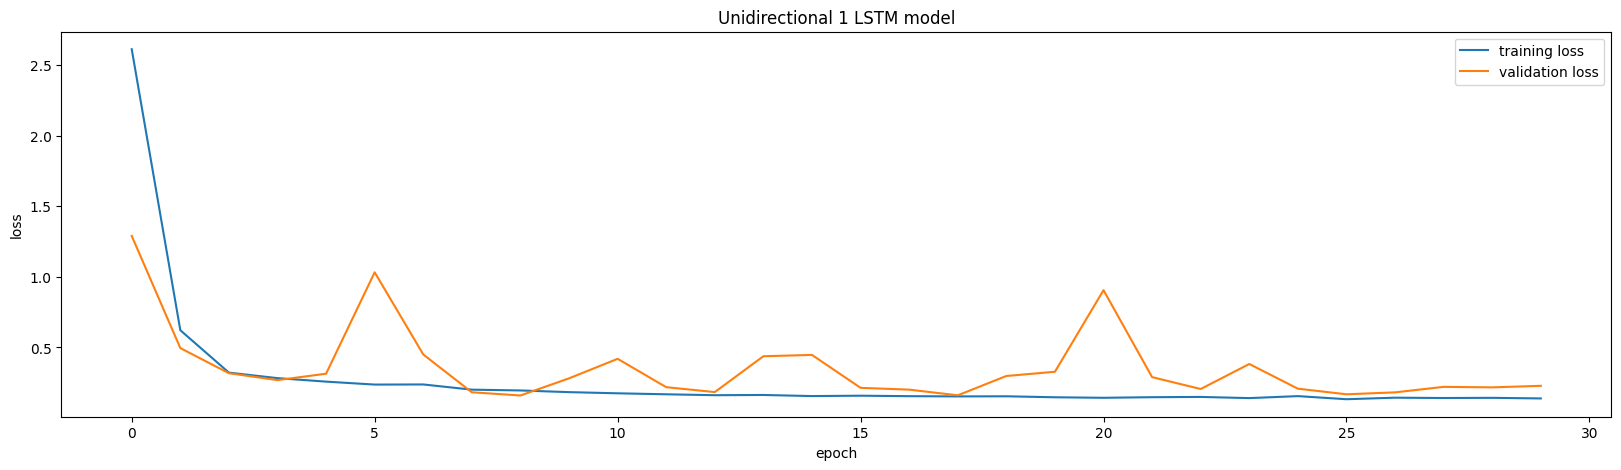

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 1 LSTM model : 0.27189776648403946
Mean Squared Error(MSE) of Unidirectional 1 LSTM model : 0.1342086617748463
Root Mean Squared Error (RMSE) of Unidirectional 1 LSTM model : 0.3663450037530829
Mean absolute percentage error (MAPE) of Unidirectional 1 LSTM model : 0.9892892892683488
Explained Variance Score (EVS) of Unidirectional 1 LSTM model : 0.9088728533983188
R2 of Unidirectional 1 LSTM model : 0.87

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


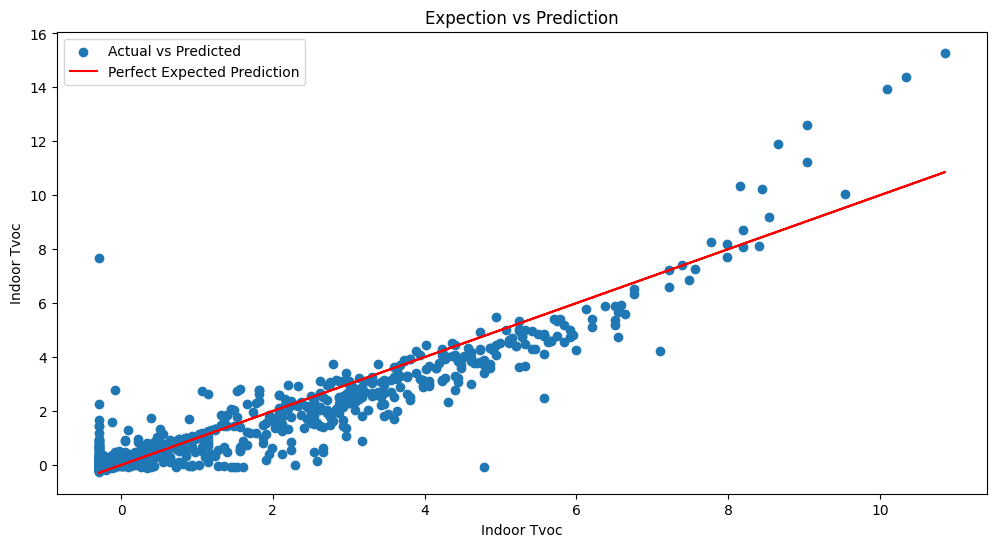

In [123]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM model', 'Indoor Tvoc')

In [124]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM model', 'Indoor Tvoc')

Epoch 1/30
227/786 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.9927

KeyboardInterrupt: 

## Humidity Prediction

In [ ]:
df_train=Computer_Room_com[["Month","Day","Hour","Minutes","Time_of_Day","TM_outdoor", "HRM%_outdoor", "humidity"]]
print(len(df_train.columns))

8


In [ ]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [ ]:
df_train = df_train.fillna(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 8)

In [ ]:
lags=15
forecasts=1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 8), (31473, 15, 8), (31473, 1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 8), (25178, 1), (6295, 15, 8), (6295, 1))

In [ ]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.temperature_model_1
bi_model = model.temperature_model_2

bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_24                │ (None, 15, 512)        │       542,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 15, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 15, 256)        │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 15, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 868,433 (3.31 MB)

 Trainable params: 868,433 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                  │ (None, 15, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,641 (596.25 KB)

 Trainable params: 152,641 (596.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0826 - val_loss: 0.0150
Epoch 2/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0150 - val_loss: 0.0040
Epoch 3/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0119 - val_loss: 0.0033
Epoch 4/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0099 - val_loss: 0.0020
Epoch 5/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0093 - val_loss: 0.0020
Epoch 6/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 7/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0074 - val_loss: 0.0021
Epoch 8/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 9/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0084 - val_loss: 0.0024
Epoch 10/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 11/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0059 - val_loss: 0.0028
Epoch 12/60
786/786 ━━━━━━━━━━

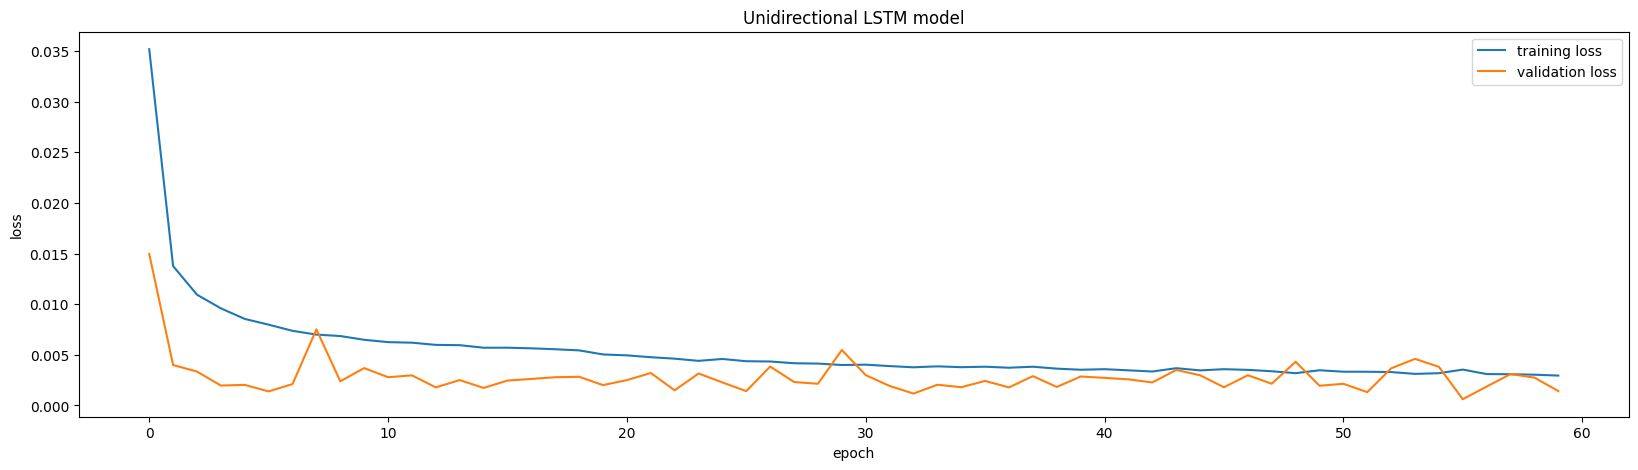

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional LSTM model : 0.028420673715454987
Mean Squared Error(MSE) of Unidirectional LSTM model : 0.0031117294484877974
Root Mean Squared Error (RMSE) of Unidirectional LSTM model : 0.05578287773580525
Mean absolute percentage error (MAPE) of Unidirectional LSTM model : 0.14984500127152675
Explained Variance Score (EVS) of Unidirectional LSTM model : 0.9969452231577095
R2 of Unidirectional LSTM model : 1.0

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


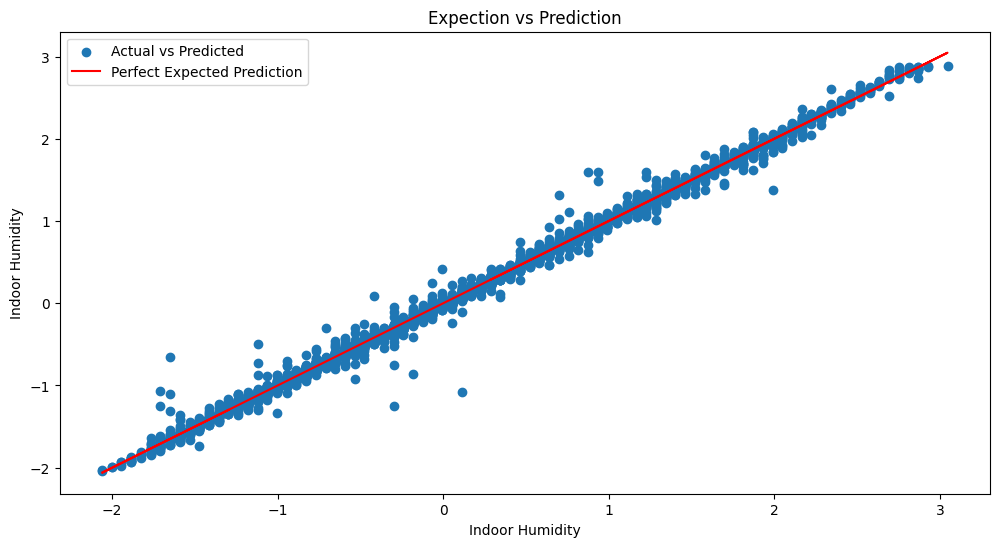

In [ ]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional LSTM model', 'Indoor Humidity')

Epoch 1/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - loss: 0.0693 - val_loss: 0.0041
Epoch 2/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.0244 - val_loss: 0.0272
Epoch 3/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.0233 - val_loss: 0.0037
Epoch 4/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0212 - val_loss: 0.0051
Epoch 5/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0197 - val_loss: 0.0052
Epoch 6/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0210 - val_loss: 0.0029
Epoch 7/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0193 - val_loss: 0.0016
Epoch 8/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0199 - val_loss: 0.0032
Epoch 9/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.0187 - val_loss: 0.0104
Epoch 10/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.0185 - val_loss: 0.0073
Epoch 11/60
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0185 - val_loss: 0.0023
Epoch 12/60
786/786 ━━━━━━━━━━

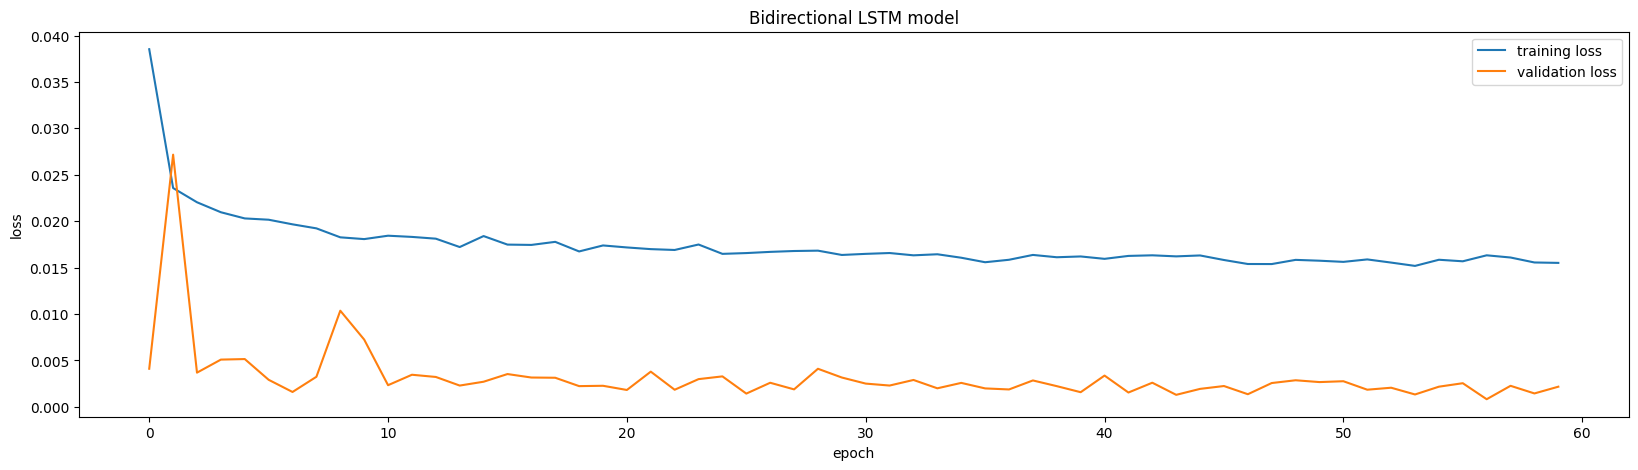

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.04114095133146774
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.0041841090895764575
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.06468468976177019
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.14976076199271882
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9958876174506752
R2 of Bidirectional LSTM model : 1.0

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


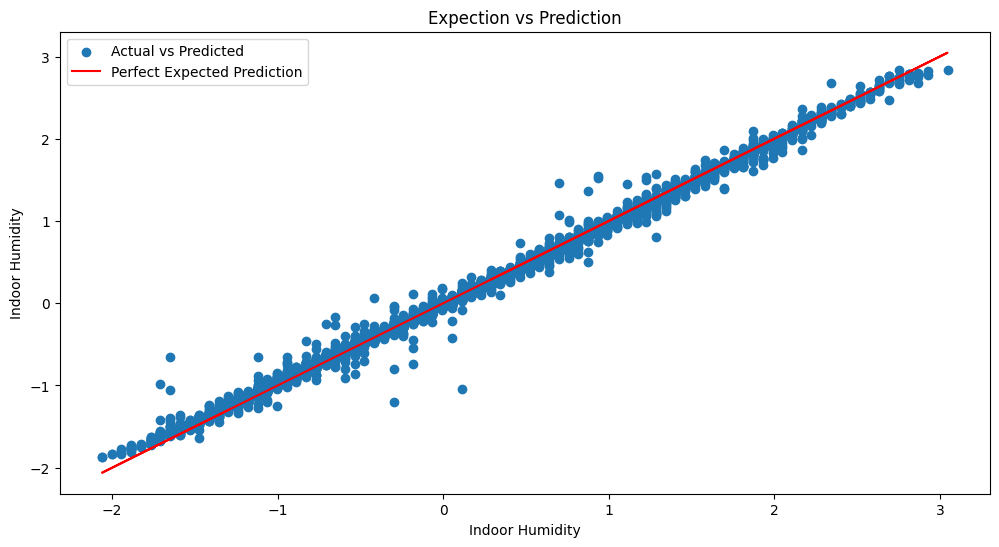

In [ ]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM model', 'Indoor Humidity')